<a href="https://colab.research.google.com/github/kellemes13/Tool/blob/main/hockeyplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


remove csv file....
['rw-4k-qd1.log.txt', 'rw-4k-qd8.log.txt', 'rw-4k-qd16.log.txt', 'rw-4k-qd32.log.txt', 'rw-4k-qd64.log.txt', 'rw-4k-qd128.log.txt', 'rw-4k-qd256.log.txt', 'rw-4k-qd512.log.txt']
iops rw-4k-qd1.log.txt 9653.0
iops rw-4k-qd8.log.txt 11100.0
iops rw-4k-qd16.log.txt 9742.0
iops rw-4k-qd32.log.txt 8603.0
iops rw-4k-qd64.log.txt 8692.0
iops rw-4k-qd128.log.txt 9840.0
iops rw-4k-qd256.log.txt 8919.0
iops rw-4k-qd512.log.txt 9750.0
CSV file has been created without headers: rw_4k_gc/rw_4k_gc_result.csv
iops: [('QD1.TXT', 9653.0), ('QD8.TXT', 11100.0), ('QD16.TXT', 9742.0), ('QD32.TXT', 8603.0), ('QD64.TXT', 8692.0), ('QD128.TXT', 9840.0), ('QD256.TXT', 8919.0), ('QD512.TXT', 9750.0)]


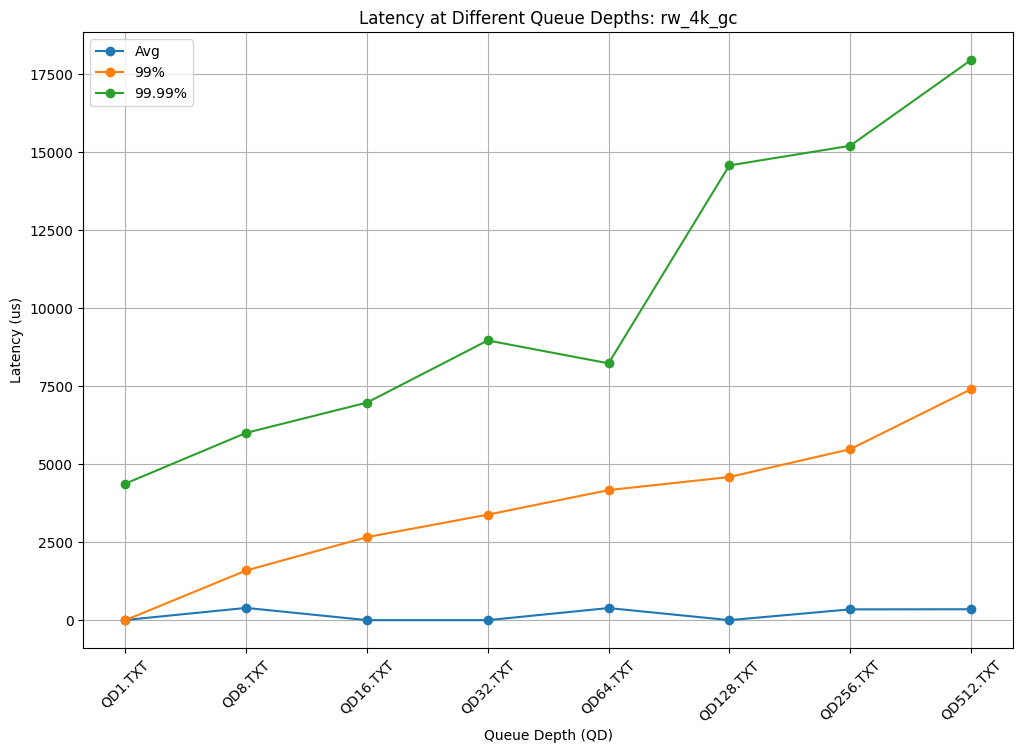

In [8]:
#create sumery to result.csv, and draw the hookey plot
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

ratio=20

# 指定包含日志文件的目录
log_directory = 'rw_4k_gc'  # 替换为你的日志文件目录路径
file_names = os.listdir(log_directory)

log_files=[]
# 遍历文件名，添加到列表中
for file_name in file_names:
    # 构造完整的文件路径
    full_path = os.path.join(log_directory, file_name)
    if file_name.endswith('.csv'):
      print('remove csv file....')
      os.remove(full_path)
    # 如果是文件，则添加到列表中
    if os.path.isfile(full_path):
        log_files.append(file_name)


# 使用正则表达式提取数字，并根据数字进行排序
sort_log_files = sorted(log_files, key=lambda x: int(re.search(r'qd(\d+)', x).group(1)))

print(sort_log_files)

# 准备存储提取数据的列表
data = []
iops_data = []

# 遍历日志文件，提取所需信息
for log_file in sort_log_files:
    file_path = os.path.join(log_directory, log_file)
    with open(file_path, 'r') as file:
        content = file.read()

        # 提取IOPS值
        iops_match = re.search(r'IOPS=([\d.]+)([kK])?,', content)
        if iops_match:
            iops_value = float(iops_match.group(1))
            # 检查是否有k单位，并进行转换
            if iops_match.group(2):
                iops_value *= 1000  # 将k单位转换为数值

        qd_value = log_file.split('-')[2].upper().replace('.LOG', '')
        iops_data.append((qd_value, iops_value))


        print('iops',log_file,iops_value)


        '''
        #ns->us clat (nsec): min=292, max=327005k, avg=94883.52,
        avg_match = re.search(r'clat \(nsec\): .* avg=(\d+\.\d+),', content)
        if avg_match:
            value1 = round(float(avg_match.group(1))/1000/ratio)
        else:
            avg_match = re.search(r'clat \(usec\): .* avg=(\d+\.\d+),', content)
            value1 = round(float(avg_match.group(1)) /ratio) if avg_match else 0  # 进行四舍五入
        '''

        #ns->us  for avg
        if 'clat (nsec):' in content:
          avg_match = re.search(r'avg=(\d+\.\d+),', content)
          value1 = round(float(avg_match.group(1))/1000/ratio)
        elif 'clat (usec):' in content:
          avg_match = re.search(r'avg=(\d+\.\d+),', content)
          value1 = round(float(avg_match.group(1))/ratio)
        elif 'clat (msec):' in content:
          avg_match = re.search(r'avg=(\d+\.\d+),', content)
          value1 = round(float(avg_match.group(1))*1000/ratio)

        #for 99% 99.99%
        if 'clat percentiles (nsec):' in content:
          percentile_99_00_match = re.search(r'99\.00th=\[\s*(\d+)\]', content)
          value2 = float(percentile_99_00_match.group(1))/1000/ratio
          percentile_99_99_match = re.search(r'99\.99th=\[\s*(\d+)\]', content)
          value3 = float(percentile_99_99_match.group(1))/1000/ratio
        elif 'clat percentiles (usec):' in content:
          percentile_99_00_match = re.search(r'99\.00th=\[\s*(\d+)\]', content)
          value2 = float(percentile_99_00_match.group(1))/ratio
          percentile_99_99_match = re.search(r'99\.99th=\[\s*(\d+)\]', content)
          value3 = float(percentile_99_99_match.group(1))/ratio
        elif 'clat percentiles (msec):' in content:
          percentile_99_00_match = re.search(r'99\.00th=\[\s*(\d+)\]', content)
          value2 = float(percentile_99_00_match.group(1))*1000/ratio
          percentile_99_99_match = re.search(r'99\.99th=\[\s*(\d+)\]', content)
          value3 = float(percentile_99_99_match.group(1))*1000/ratio


        '''
        #us
        match = re.search(r'clat percentiles \(usec\):', content)
        if match:
            percentile_99_00_match = re.search(r'99\.00th=\[\s*(\d+)\]', content)
            value2 = float(percentile_99_00_match.group(1)) if percentile_99_00_match else 0
            value2=round(value2/ratio)

            percentile_99_99_match = re.search(r'99\.99th=\[\s*(\d+)\]', content)
            value3 = float(percentile_99_99_match.group(1)) if percentile_99_99_match else 0
            value3=round(value3/ratio)
        else:
            match = re.search(r'clat percentiles \(msec\):', content)
            percentile_99_00_match = re.search(r'99\.00th=\[\s*(\d+)\]', content)
            value2 = float(percentile_99_00_match.group(1)) if percentile_99_00_match else 0
            value2=round(value2*1000/ratio)

            percentile_99_99_match = re.search(r'99\.99th=\[\s*(\d+)\]', content)
            value3 = float(percentile_99_99_match.group(1)) if percentile_99_99_match else 0
            value3=round(value3*1000/ratio)
        '''


        # 根据要求格式化QD值，移除".LOG"
        qd_value = log_file.split('-')[2].upper().replace('.LOG', '')

        # 添加提取的数据到列表
        data.append([qd_value, value1, value2, value3])

# 创建DataFrame
df = pd.DataFrame(data)

# 保存DataFrame到CSV文件，不包含标题行
filename=log_directory+'_'+'result.csv'
csv_file_path = os.path.join(log_directory, filename)
df.to_csv(csv_file_path, index=False, header=False)

print(f"CSV file has been created without headers: {csv_file_path}")


#csv_file_path = 'result.csv'  # 请替换为实际的CSV文件路径

# 读取CSV文件
df = pd.read_csv(csv_file_path, header=None, names=['QD', 'Value1', 'Value2', 'Value3'])

# 解析'QD'列作为X轴数据
x_labels = df['QD'].tolist()

# 获取Y轴数据
y1 = df['Value1'].tolist()
y2 = df['Value2'].tolist()
y3 = df['Value3'].tolist()

# 绘制图表
plt.figure(figsize=(12, 8))

plt.plot(x_labels, y1, label='Avg', marker='o')
plt.plot(x_labels, y2, label='99%', marker='o')
plt.plot(x_labels, y3, label='99.99%', marker='o')

# 新增：绘制IOPS值
print('iops:',iops_data)

plt.xlabel('Queue Depth (QD)')
plt.ylabel('Latency (us)')
plt.title('Latency at Different Queue Depths: '+ log_directory)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
